In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [2]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import sys
sys.path.insert(0, '../.')
from data.detection_dataset_loader import *
from scipy.spatial.transform import Rotation as R
from data.data_utils.data_reader import *
import math
import numpy.matlib as npm


/Users/apple/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def convert5Pointto8Point(cx_, cy_, w_, h_, a_):

    theta = math.radians(a_)
    bbox = npm.repmat([[cx_], [cy_]], 1, 5) + \
       np.matmul([[math.cos(theta), math.sin(theta)],
                  [-math.sin(theta), math.cos(theta)]],
                 [[-w_ / 2, w_/ 2, w_ / 2, -w_ / 2, w_ / 2 + 8],
                  [-h_ / 2, -h_ / 2, h_ / 2, h_ / 2, 0]])
    # add first point
    x1, y1 = bbox[0][0], bbox[1][0]
    # add second point
    x2, y2 = bbox[0][1], bbox[1][1]
    # add third point
    #x3, y3 = bbox[0][4], bbox[1][4]   
    # add forth point
    x3, y3 = bbox[0][2], bbox[1][2]
    # add fifth point
    x4, y4 = bbox[0][3], bbox[1][3]

    return [x1, y1, x2, y2, x3, y3, x4, y4]


In [4]:
def get_augmentation_parameters( training):
        if training:

                    if np.random.random_sample() >= 0.5:
                        image_translate_x = random.randint(-50, 50)
                    else:
                        image_translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        image_translate_y = random.randint(-25, 25)
                    else:
                        image_translate_y = 0

                    if np.random.random_sample() >= 0.5:
                        translate_x = random.randint(-5, 5)
                    else:
                        translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        translate_y = random.randint(-5, 5)
                    else:
                        translate_y = 0

                    if np.random.random_sample() >= 0.8:
                        translate_z = random.random() - 0.5
                    else:
                        translate_z = 0

                    if np.random.random_sample() >= 0.3:
                        ang = random.randint(-5, 5)
                    else:
                        ang = 0

                    r = R.from_rotvec(np.radians(ang) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = translate_x
                    tr_y = translate_y
                    tr_z = translate_z
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                    
                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    
                    sc_x = 1
                    sc_y = 1
                    sc_z = 1

                    # if np.random.random_sample() >= 0.5:
                    #    sc_x += ((random.random() * 2) - 1.) / 10.

                    # if np.random.random_sample() >= 0.5:
                    #    sc_y += ((random.random() * 2) - 1.) / 10.


                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])
                    

        else:
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

        return rot, tr, sc, image_translate_x, image_translate_y, ang

In [5]:
training=True
base_path = '/Users/apple/Desktop/Master/Data/'
list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files)

camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
        
ln = int(len(list_files) * 0.5)
final_sample = len(list_files)

# ln = int(10 * 0.5)
# final_sample = 10
        
if training:
            list_files = list_files[:ln]
            list_camera_paths = camera_paths[:ln]
            list_lidar_paths = lidar_paths[:ln]
            list_label_paths = label_paths[:ln]
            list_calib_paths = calib_paths[:ln]
else:
            list_camera_paths = camera_paths[ln:final_sample]
            list_lidar_paths = lidar_paths[ln:final_sample]
            list_label_paths = label_paths[ln:final_sample]
            list_calib_paths = calib_paths[ln:final_sample]
            list_files = list_files[ln:final_sample]


In [6]:
i_c = 2

In [88]:
rot, tr, sc, image_translate_x, image_translate_y, ang = get_augmentation_parameters(False)
# print(rot)
# print(tr)
# print(sc)
# print(ang)
data_reader_obj = DataReader(list_camera_paths[i_c],
                             list_calib_paths[i_c], 
                             list_label_paths[i_c], 
                             list_lidar_paths[i_c], 
                             rot, sc, tr, ang, image_translate_x, image_translate_y, get_actual_dims=True)

camera_image = data_reader_obj.read_image()
lidar_image = data_reader_obj.lidar_reader.read_lidar()
_, label, directions = data_reader_obj.label_reader.read_label()
# label = get_target(label, directions,  anchors=anchors)

In [90]:
def get_target2(labels, directions, anchors=np.array([3.9, 1.6, 1.5]), input_size=(512, 448), output_size=(128, 112)):
    # ASSUMPTION: I will assume that the anchors contain a record for the height
    """
    - calculate the ratio = input size / final output size
    - divide each of the x, y and z by the ratio
    - subtract each of the x, y and z ....
    """

    ratio = input_size[0] // output_size[0]
    y_target = np.zeros((output_size[0], output_size[1], 2, 9), np.float32)
   
    for i in range(len(labels)):
        label_i = np.array(labels[i])
        print(label_i)

        x = int(label_i[0]/ratio)
        y = int(label_i[1]/ratio)

        if x >= output_size[0]:
            x = output_size[0] - 1
        if y >= output_size[1]:
            y = output_size[1] - 1

        if x < 0 or y < 0:
            continue

        label_i[0:2] = label_i[0:2] / (ratio*1.0)
        label_i[2] = label_i[2] / 40.

        if label_i[6] < 0:
            label_i[6] += 3.14

        angle = label_i[6] * 57.2958
        if (angle >= 0 and angle <= 45) or (angle >= 135 and angle <= 225) or (angle >= 315 and angle <= 360):
            k = 0
        else:
            k = 1

        if label_i[6] >= 3 * np.pi / 4:
            label_i[6] = label_i[6] - np.pi
        
        label_i[6] = label_i[6] - k * (np.pi/2)

        anchor = np.array([x+0.5, y+0.5, 1., anchors[0], anchors[1], anchors[2]])
    
        label_i[:3] = (label_i[:3] - anchor[:3]) / anchor[3:6]
        label_i[3:6] = np.log(label_i[3:6]/anchors)

        y_target[x, y, k, :7] = label_i
        y_target[x, y, k, 7:8] = [directions[i]]
        y_target[x, y, k, 8:9] = [1]
        print(x, y, k, y_target[x, y, k, :])
    return y_target

In [97]:
label2 = get_target2(label, directions, anchors=np.array([3.9, 1.6, 1.5]))

[338.04296048 228.30154101  26.25161283  22.99242145   9.29960799
  15.69576782   1.66      ]
84 57 1 [ 0.00275388 -0.26538423 -0.22913979  1.7741882   1.7599686   2.347926
  0.08920367  0.          1.        ]
[ 32.24609223 225.6971858   22.65440982  26.15529828   9.0992046
  14.03845072   1.76      ]
8 56 1 [-0.11242998 -0.04731472 -0.28909317  1.9030752   1.7381834   2.236335
  0.18920368  1.          1.        ]
[ 18.71120729 212.1119288   23.38243312  24.10031383   8.63705486
  13.745983     1.75      ]
4 53 1 [ 0.04559021 -0.29501113 -0.27695945  1.8212483   1.686058    2.2152815
  0.17920367  1.          1.        ]


In [101]:
(26.25161283/40 - 1) / 1.5

-0.22913978616666672

In [103]:
-0.22913978616666672 * 1.5 + 1

0.6562903207499999

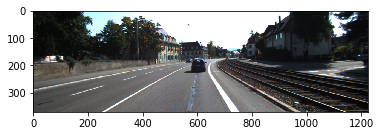

In [73]:
plt.imshow(camera_image)
plt.show()

In [74]:
lidar_image.shape

(512, 448, 41)

In [75]:
np.max(lidar_image), np.min(lidar_image)

(1.007874, -1.0)

338.0429604813074 228.30154100755286 26.251612833821447 22.992421447451175 9.299607994828627 15.695767823076704 -95.111028
32.2460922309657 225.697185802592 22.654409815824067 26.155298277685983 9.0992046028595 14.038450723745626 -100.840608
18.71120728895272 212.1119287974117 23.382433123893723 24.100313833726535 8.637054861396004 13.745983000334258 -100.26765


<Figure size 432x288 with 0 Axes>

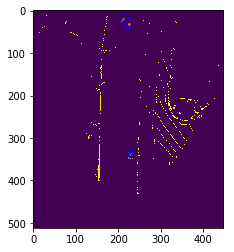

In [76]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*127. + 127.)

img = np.clip(np.mean(img[:, :, 5:25], 2), 0, 1)

ax.imshow(img)

# print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    d = label[i][5] 
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    plt.scatter([y], [x], s=3)
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=.75,edgecolor='b',facecolor='none')
    ax.add_patch(rect)
    print(x, y, z, w, h, d, -label[i][6]*57.2958)


plt.show()


<Figure size 432x288 with 0 Axes>

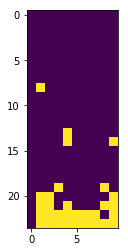

In [82]:
plt.clf()
fig,ax = plt.subplots(1)
# 338.0429604813074 228.30154100755286 26.251612833821447 22.992421447451175 9.299607994828627 15.695767823076704 -95.111028

img = (lidar_image*127. + 127.)
img = np.clip(np.mean(img[338-12:338+12, 228-5:228+5, 5:25], 2), 0, 1)
ax.imshow(img)
plt.show()

15.695767823076704 9.299607994828627 22.992421447451175
228.30154100755286 26.251612833821447 338.0429604813074
14.038450723745626 9.0992046028595 26.155298277685983
225.697185802592 22.654409815824067 32.2460922309657
13.745983000334258 8.637054861396004 24.100313833726535
212.1119287974117 23.382433123893723 18.71120728895272


<Figure size 432x288 with 0 Axes>

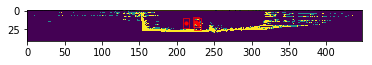

In [78]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

img = (lidar_image*127. + 127.)
# Display the image
img = np.clip(np.mean(img.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z-h/2, s=10, c='r')
    a = label[i][6]
    if a < 0:
      a = a + 3.14
    print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle=0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
#     break


plt.show()


<Figure size 432x288 with 0 Axes>

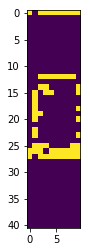

In [80]:
plt.clf()
fig,ax = plt.subplots(1)
# 15.695767823076704 9.299607994828627 22.992421447451175
# 228.30154100755286 26.251612833821447 338.0429604813074


# 15.695767823076704 9.27595552418579 23.02796916185907
# 217.70232382225657 26.251612833821447 316.5861802528655
img = (lidar_image*127. + 127.)
img = np.clip(np.mean(img.transpose()[:, 228-5:228+5, 338-11:338+11], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)
plt.show()